# Expedia Hotel Ranking Problem

## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

## Import Datasets
Read training and testing datasets and parse the date to integers, as this will be useful for the algorithm, otherwise it will be interpreted as a categorical variable.

In [2]:
data = pd.read_csv("./train.csv")
data["srch_date_time"] = pd.to_datetime(data.srch_date_time)
data["integer_time"] = data['srch_date_time'].dt.strftime("%Y%m%d%H%M%S")
data.integer_time = pd.to_numeric(data.integer_time, errors='coerce')

testingData = pd.read_csv("./test.csv")
testingData["srch_date_time"] = pd.to_datetime(testingData.srch_date_time)
testingData["integer_time"] = testingData['srch_date_time'].dt.strftime("%Y%m%d%H%M%S")
testingData.integer_time = pd.to_numeric(testingData.integer_time, errors='coerce')

## EDA
Look for Null Values

In [3]:
{column: data[column].isnull().sum() for column in data.columns if data[column].isnull().sum() > 0}

{'srch_visitor_loc_region': 123,
 'srch_visitor_wr_member': 444878,
 'srch_posa_continent': 485248,
 'srch_adults_cnt': 18,
 'srch_children_cnt': 18,
 'srch_currency': 134104,
 'prop_price_without_discount_local': 51,
 'prop_price_without_discount_usd': 51,
 'prop_price_with_discount_local': 51,
 'prop_price_with_discount_usd': 51,
 'prop_review_score': 8,
 'prop_review_count': 8}

In [4]:
{column: testingData[column].isnull().sum() for column in testingData.columns if testingData[column].isnull().sum() > 0}

{'srch_visitor_loc_region': 111,
 'srch_visitor_wr_member': 181968,
 'srch_posa_continent': 202751,
 'srch_currency': 53400,
 'prop_price_without_discount_local': 11,
 'prop_price_without_discount_usd': 11,
 'prop_price_with_discount_local': 11,
 'prop_price_with_discount_usd': 11,
 'prop_review_score': 6,
 'prop_review_count': 6}

As the number of null values in `srch_visitor_wr_member`, `srch_posa_continent` and `srch_currency` are very high, these columns can be removed. Furthermore, it is not necessary to have the local currency columns for discount and non-discount prices, becuase this is just a transformation and having everything in usd is better. So `prop_price_without_discount_local` and `prop_price_with_discount_local` can also be removed.

In [5]:
data.drop(['srch_visitor_wr_member', "srch_posa_continent", "srch_currency", "prop_price_without_discount_local", "prop_price_with_discount_local", "srch_date_time", "srch_local_date", "srch_mobile_app"], axis=1, inplace=True)

In [6]:
testingData.drop(['srch_visitor_wr_member', "srch_posa_continent", "srch_currency", "prop_price_without_discount_local", "prop_price_with_discount_local", "srch_date_time", "srch_local_date", "srch_mobile_app"], axis=1, inplace=True)

Remaining Columns

In [7]:
data.columns

Index(['srch_id', 'prop_key', 'srch_visitor_id', 'srch_visitor_visit_nbr',
       'srch_visitor_loc_country', 'srch_visitor_loc_region',
       'srch_visitor_loc_city', 'srch_posa_country',
       'srch_hcom_destination_id', 'srch_dest_longitude', 'srch_dest_latitude',
       'srch_ci', 'srch_co', 'srch_ci_day', 'srch_co_day', 'srch_los',
       'srch_bw', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_mobile_bool', 'srch_device', 'prop_travelad_bool',
       'prop_dotd_bool', 'prop_price_without_discount_usd',
       'prop_price_with_discount_usd', 'prop_imp_drr', 'prop_booking_bool',
       'prop_brand_bool', 'prop_starrating', 'prop_super_region',
       'prop_continent', 'prop_country', 'prop_market_id', 'prop_submarket_id',
       'prop_room_capacity', 'prop_review_score', 'prop_review_count',
       'prop_hostel_bool', 'integer_time'],
      dtype='object')

## Data Summary

In [8]:
data.describe()

,srch_id,prop_key,srch_visitor_visit_nbr,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci_day,srch_co_day,srch_los,srch_bw,...,prop_booking_bool,prop_brand_bool,prop_starrating,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,integer_time
count,8.411150e+05,8.411150e+05,841115.000000,8.411150e+05,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,...,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841107.000000,841107.000000,841115.000000,8.411150e+05
mean,1.724233e+07,8.185569e+05,12.325977,1.194309e+06,-45.892803,40.445932,4.272102,3.689650,2.677238,35.349157,...,0.028549,0.664118,3.595627,71586.980101,106494.270656,631.116457,4.024048,2160.753578,0.002888,2.014091e+13
std,1.231757e+09,1.141255e+06,31.788936,4.237267e+05,77.706051,6.056537,2.003199,2.128168,2.192103,49.506785,...,0.166535,0.472298,0.864574,39165.985756,7384.185494,1573.071335,0.547170,3075.169206,0.053661,1.540989e+07
min,-2.147275e+09,2.407460e+05,1.000000,5.042610e+05,-115.172875,28.541290,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,369.000000,60556.000000,-9998.000000,0.000000,0.000000,0.000000,2.014083e+13
25%,-1.034005e+09,2.559520e+05,1.000000,7.267840e+05,-115.172875,36.114666,3.000000,2.000000,1.000000,4.000000,...,0.000000,0.000000,3.000000,60039.000000,98238.000000,144.000000,3.800000,306.000000,0.000000,2.014091e+13
50%,3.193952e+07,2.777420e+05,3.000000,1.497539e+06,-73.986473,40.756680,5.000000,4.000000,2.000000,17.000000,...,0.000000,1.000000,4.000000,95602.000000,109153.000000,306.000000,4.100000,937.000000,0.000000,2.014091e+13
75%,1.081646e+09,4.781330e+05,10.000000,1.504033e+06,-0.127804,41.880779,6.000000,6.000000,3.000000,46.000000,...,0.000000,1.000000,4.000000,95656.000000,110287.000000,770.000000,4.400000,2550.000000,0.000000,2.014092e+13
max,2.147266e+09,3.949856e+06,1082.000000,1.506246e+06,139.759995,51.507538,7.000000,7.000000,28.000000,473.000000,...,1.000000,1.000000,5.000000,116356.000000,116928.000000,19235.000000,5.000000,32399.000000,1.000000,2.014093e+13


`prop_room_capacity` has negative values which will need investigating and `srch_mobile_app` has all 0 values therefore can also be dropped

### Looking at the negative room situation

In [9]:
data.groupby('prop_room_capacity')['srch_id', 'prop_key'].nunique()

,srch_id,prop_key
prop_room_capacity,,
-9998,6978,103
0,1151,3
1,177,98
2,62,24
3,139,49
...,...,...
4008,4580,1
4049,4641,1
4204,3821,1


All negative values are `-9998` which cant be a conincedence,, so we can fill it with NA instead.

In [10]:
len(data)

841115

In [11]:
data.loc[data.prop_room_capacity < 0, 'prop_room_capacity'] = None
testingData.loc[testingData.prop_room_capacity < 0, 'prop_room_capacity'] = None

## Find Categorical Variables and Encode them

In [12]:
data.describe(exclude=[np.number])

,srch_visitor_id,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_posa_country,srch_ci,srch_co,srch_device,prop_super_region,prop_continent,prop_country
count,841115,841115,840992,841115,841115,841115,841115,841115,841115,841115,841115
unique,23101,151,599,5092,67,385,376,3,4,4,7
top,0fac9b35-d7b7-4b71-b275-7da40310ea2e,UNITED STATES OF AMERICA,CA,NEW YORK,US,2014-09-26,2014-09-28,DESKTOP,AMER,NORTHAMERICA,UNITED STATES OF AMERICA
freq,800,463183,115310,21172,463532,23604,28497,718871,554304,554304,554304


In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df2 = data.copy()
for column in df2.select_dtypes(exclude=[np.number]).columns:
    df2[column] = le.fit_transform(df2[column].astype(str))
# df2.dropna(inplace=True)
data = df2.copy()

In [14]:
df3 = testingData.copy()
for column in df3.select_dtypes(exclude=[np.number]).columns:
    df3[column] = le.fit_transform(df3[column].astype(str))
# df3.dropna(inplace=True)
testingData = df3.copy()

In [15]:
from sklearn.utils import shuffle

numericData = data.copy()
numericData = shuffle(numericData)
numericData.reset_index(inplace=True, drop=True)
x = numericData.drop(['prop_booking_bool'], axis=1)
y = numericData['prop_booking_bool']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42, shuffle=True)

### Dealing With Imbalanced Data

In [16]:
weighting = numericData.groupby(['prop_booking_bool']).size()
weighting

prop_booking_bool
0    817102
1     24013
dtype: int64

We can estimate the `scale_pos_weight` by doing:

`number of negative examples / number of positive examples` as suggested in the XGBoost Documentation

https://xgboost.readthedocs.io/en/latest/parameter.html

In [17]:
scale_pos_weight = weighting[0]/weighting[1]
scale_pos_weight

34.02748511223088

In [18]:
import xgboost as xgb
from xgboost import DMatrix, train

# training_group = x_train.groupby(["srch_id"]).size().values
# xgb_train = DMatrix(x_train, label=y_train)
# xgb_train.set_group(training_group)

# evaluation_group = x_test.groupby(["srch_id"]).size().values
# xgb_eval = DMatrix(x_test, label=y_test)
# xgb_eval.set_group(evaluation_group)

# evaluation_set = [(xgb_train, 'train'), (xgb_eval, "eval")]

training_group = x.groupby(["srch_id"]).size().values
xgb_train = DMatrix(x, label=y)
xgb_train.set_group(training_group)

evaluation_set = [(xgb_train, 'train')]

## Hyper Parameter Tuning

`{redacted}`

In [40]:
%time ranking_model = train(params, xgb_train, evals=evaluation_set, num_boost_round=1000, early_stopping_rounds=10)

`run following code as many times as you want to increase AUC, not sure if this increases score though`

best AUC score = `0.89833`

In [ ]:
%time ranking_model = train(params, xgb_train, evals=evaluation_set, num_boost_round=100, xgb_model=ranking_model)

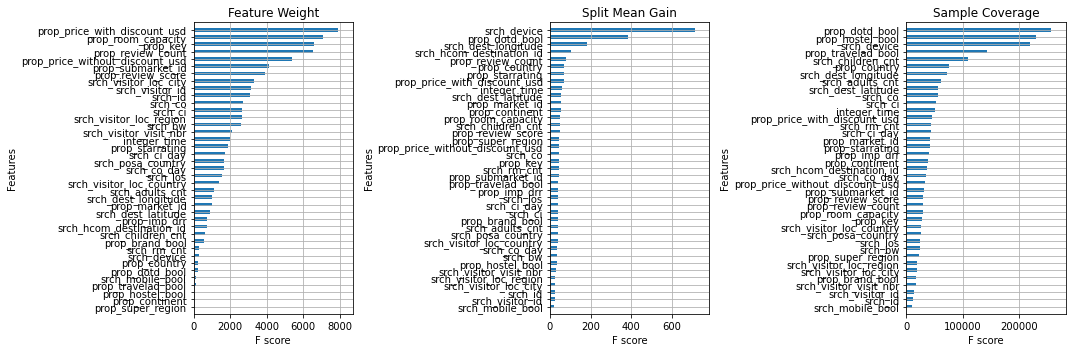

In [30]:
xgc = ranking_model
# saving the feature names to the model
xgc.feature_names = x_train.columns.to_list()
# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(15,5))
# plot importances with feature weight
xgb.plot_importance(
    booster=xgc, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgc,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    booster=xgc,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

Features with almost no weight are useless so can be dropped

In [ ]:
newX = x.drop(['prop_hostel_bool', 'prop_super_region', 'prop_travelad_bool', 'prop_continent', 'prop_dotd_bool', 'srch_mobile_bool', 'srch_device'], axis=1)

In [ ]:
import xgboost as xgb
from xgboost import DMatrix, train

training_group = newX.groupby(["srch_id"]).size().values
xgb_train = DMatrix(newX, label=y)
xgb_train.set_group(training_group)

evaluation_set = [(xgb_train, 'train')]

In [ ]:
%time ranking_model_reduced = train(params, xgb_train, evals=evaluation_set, num_boost_round=100)

In [ ]:
%time ranking_model_reduced = train(params, xgb_train, evals=evaluation_set, num_boost_round=10, xgb_model=ranking_model_reduced)

By reducing the model, a new highscore for AUC of `0.9001` was achieved

In [ ]:
# Reduced Model
newTestingData = testingData.drop(['prop_hostel_bool', 'prop_super_region', 'prop_travelad_bool', 'prop_continent', 'prop_dotd_bool', 'srch_mobile_bool', 'srch_device'], axis=1)
mat = DMatrix(newTestingData)
predictions = ranking_model_reduced.predict(mat)
testingNumericData = newTestingData.copy()
testingNumericData['predictions'] = predictions
results = testingNumericData[["srch_id", "prop_key", "predictions"]]

In [36]:
# Previous Model
mat = DMatrix(testingData)
predictions = ranking_model.predict(mat)
testingNumericData = testingData.copy()
testingNumericData['predictions'] = predictions
results = testingNumericData[["srch_id", "prop_key", "predictions"]]

In [37]:
results_to_csv = results.sort_values(['srch_id'], ascending=True).groupby(['srch_id'], sort=False).apply(lambda x: x.sort_values(['predictions'], ascending=False)).reset_index(drop=True)

In [38]:
submissions = results_to_csv[["srch_id", "prop_key"]]
submissions.to_csv("./submission2.csv", index=False)